## 事前分布の設定が大事！！
データ少なくてもうまく予測できるよ！

In [108]:
import numpy as np
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import tensorflow_probability as tfp
import pymc3 as pm
%matplotlib inline

$$\mu_y=ax+b$$
$$\mu_a=c(x-d)^2+e$$

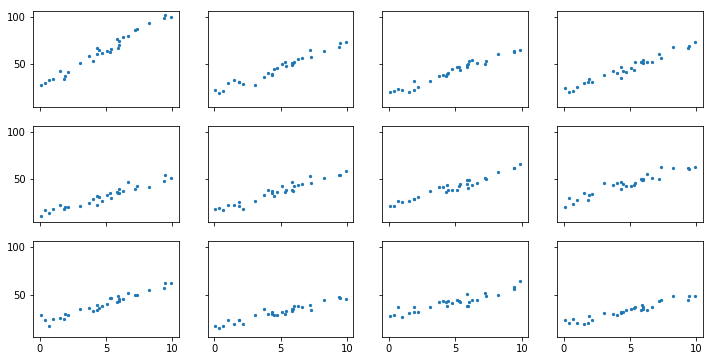

In [79]:
# simulation data
n_area = 12
n_sample = 30
c = 0.2
d = 5.0
e = 3.0
sig_a = 0.1
sig_y = 3.0

random.seed(8)
z = random.uniform(0, 5, size=n_area)
z.sort()

# mu_a = 2.0 * np.tanh(z - 2.0) + 3.0 
mu_a = c * (z - d) **2 + e
 
a = random.normal(mu_a, sig_a)
b = random.normal(20, 5, n_area)

x = random.uniform(0, 10, n_sample)
x.sort()

mu_y = np.dot(x.reshape(-1, 1), a.reshape(1, -1))  + b
y = random.normal(mu_y, sig_y)

fig, axes = plt.subplots(3, 4, figsize=(12, 6), sharex=True, sharey=True)
for i in range(n_area):
    ax = axes.ravel()[i]
    ax.scatter(x, y[:,i], s=5)

(0, 130)

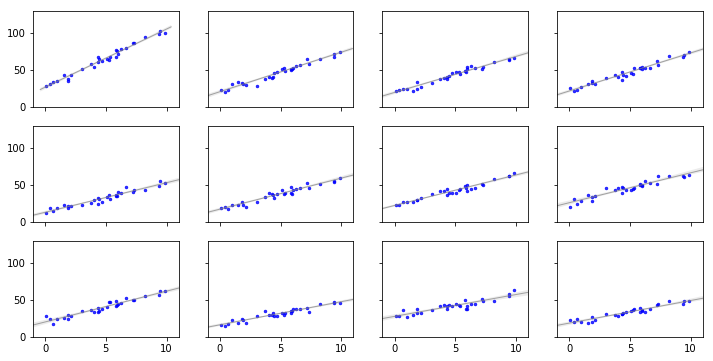

In [101]:
fig, axes = plt.subplots(3, 4, figsize=(12, 6), sharex=True, sharey=True)
for i in range(n_area):
    ax = axes.ravel()[i]
    sns.regplot(x=x, y=y[:,i], ax=ax, 
                scatter_kws={'s': 6, 'alpha': 0.8, 'color': 'b'}, 
                line_kws={'color': 'gray', 'lw': 1, 'alpha': 0.7})
plt.xlim(-1, 11)
plt.ylim(0, 130)

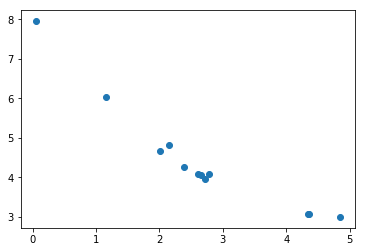

In [80]:
# relationship between z and a(slope)
plt.scatter(z, a)

## Linear regression

(0, 100)

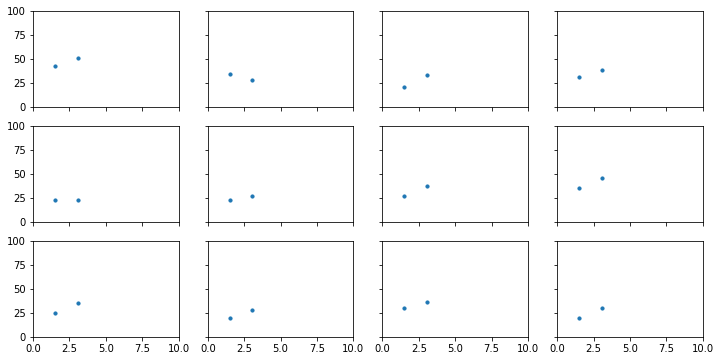

In [105]:
# assume only two are observed
obs_id = [4, 8]

fig, axes = plt.subplots(3, 4, figsize=(12, 6), sharex=True, sharey=True)
for i in range(n_area):
    ax = axes.ravel()[i]
    ax.scatter(x[obs_id], y[obs_id, i], s=10)

plt.xlim(0, 10)
plt.ylim(0, 100)

(0, 100)

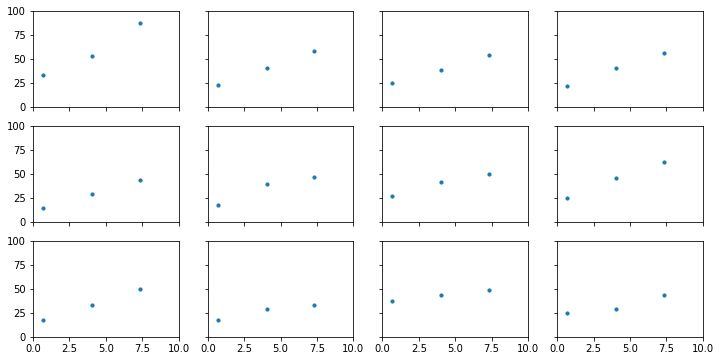

In [106]:
obs_id = [2, 10, 25]

fig, axes = plt.subplots(3, 4, figsize=(12, 6), sharex=True, sharey=True)
for i in range(n_area):
    ax = axes.ravel()[i]
    ax.scatter(x[obs_id], y[obs_id, i], s=10)
plt.xlim(0, 10)
plt.ylim(0, 100)

In [177]:
# 正解の回帰直線
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), y)
a_true, b_true = lr.coef_, lr.intercept_

xx = np.linspace(0, 10)
mu_true = a_true.ravel()[i] * xx + b_true[i]

In [115]:
obs_id = [4, 8]
x_obs, y_obs = x[obs_id], y[obs_id]

$$\mu_y=a_i x+b$$
$$\mu_{a,i}=c(x_i-d)^2+e$$
$i$ is the index for areas　　

c = 0.2, d = 5.0, e = 3.0

In [178]:
# uninformative prior
d = 5.0 # known from past data

with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    c = pm.Normal('c', mu=0.2, sd=10)
    e = pm.Normal('e', mu=3.0, sd=10)
    mu_a = pm.Deterministic('mu_a', c * (z - d) ** 2 + e)
    
    a = pm.Normal('a', mu=mu_a, sd=sig_a, shape=(1, n_area))
    b = pm.Normal('b', mu=10.0, sd=50, shape=(1, n_area))
    sig_y = pm.HalfCauchy('sig_y', beta=5)

    # Define likelihood
    mu = pm.Deterministic('mu', pm.math.dot(x_obs[:,np.newaxis], a) + b)
    Y = pm.Normal('Y', mu=mu, sd=sig_y, observed=y_obs)

    # Inference!
    prior = pm.sample_prior_predictive()
    trace = pm.sample(1000, cores=3, chains=3)

Sampling 3 chains: 100%|██████████| 4500/4500 [00:48<00:00, 92.34draws/s] 
W0926 17:38:02.770724 4473443776 report.py:143] The acceptance probability does not match the target. It is 0.6755086218211873, but should be close to 0.8. Try to increase the number of tuning steps.
W0926 17:38:02.771744 4473443776 report.py:143] The acceptance probability does not match the target. It is 0.9064596443208449, but should be close to 0.8. Try to increase the number of tuning steps.


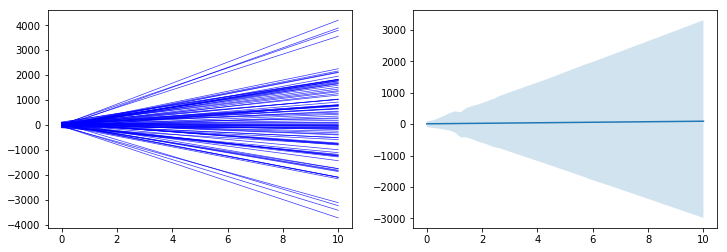

In [154]:
def plot_lr_sample(x, slope_sample, intercept_sample, axes):
    mu_sample = np.dot(slope_sample, x.reshape(1, -1)) + intercept_sample

    for i in range(100):
        axes[0].plot(x, mu_sample[i], color='b', lw=0.7, alpha=0.8)

    sig_mu = pm.hpd(mu_sample)
    mu_mean = mu_sample.mean(axis=0)
    axes[1].plot(x, mu_mean)
    axes[1].fill_between(x, sig_mu[:, 0], sig_mu[:,1], alpha=0.2)


# area i
i = 1
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_lr_sample(xx, prior['a'][:,:,i], prior['b'][:,:,i], axes)

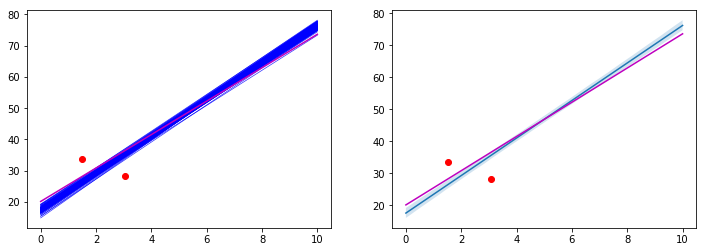

In [175]:
## prediction
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_lr_sample(xx, trace['a'][:,:,i], trace['b'][:,:,i], axes)

for ax in axes:
    ax.scatter(x_obs, y_obs[:,i], color='r', zorder=1000)
    ax.plot(xx, mu_true, color='m')

In [156]:
# informative prior
d = 5.0 # known from past data

with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    c = pm.Normal('c', mu=0.2, sd=0.1)
    e = pm.Normal('e', mu=3.0, sd=1.0)
    mu_a = pm.Deterministic('mu_a', c * (z - d) ** 2 + e)
    
    a = pm.Normal('a', mu=mu_a, sd=sig_a, shape=(1, n_area))
    b = pm.Normal('b', mu=10.0, sd=5.0, shape=(1, n_area))
    sig_y = pm.HalfNormal('sig_y', sd=10.0)

    # Define likelihood
    mu = pm.Deterministic('mu', pm.math.dot(x[:,np.newaxis], a) + b)
    Y = pm.Normal('Y', mu=mu, sd=sig_y, observed=y)

    # Inference!
    prior = pm.sample_prior_predictive()
    trace = pm.sample(1000, cores=3, chains=3)

Sampling 3 chains: 100%|██████████| 4500/4500 [00:07<00:00, 580.96draws/s]


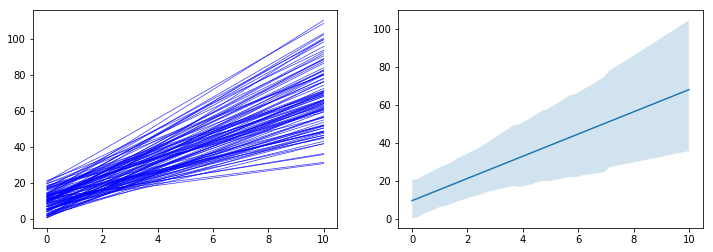

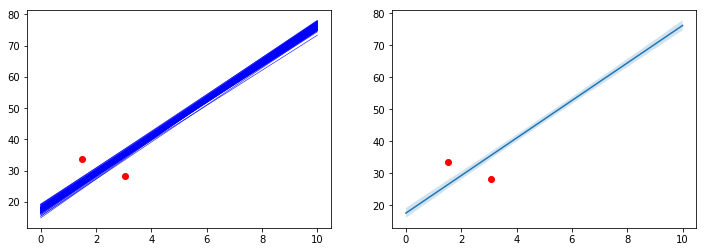

In [157]:
# area i
i = 1
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_lr_sample(xx, prior['a'][:,:,i], prior['b'][:,:,i], axes)


## prediction
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_lr_sample(xx, trace['a'][:,:,i], trace['b'][:,:,i], axes)

for ax in axes:
    ax.scatter(x_obs, y_obs[:,i], color='r', zorder=1000)